In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [18]:
data_length = 15000
stocks = ['9064', '9061', '9265']
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d, d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=False, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = d['queue_imbalance'].shift()
    d_test['prev_queue_imbalance'] = d_test['queue_imbalance'].shift()
    d.dropna(inplace=True)
    d_test.dropna(inplace=True)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
for s in stocks:
    print(s)
    print(min(d_stocks[s].index), max(d_stocks[s].index))
    print(min(d_test_stocks[s].index), max(d_test_stocks[s].index))

9064
2013-09-12 14:42:00 2013-11-05 13:32:00
2013-09-02 09:01:00 2013-09-12 14:40:00
9061
2013-09-13 10:37:00 2013-11-06 14:54:00
2013-09-02 09:01:00 2013-09-13 10:35:00
9265
2013-09-16 09:46:00 2013-11-12 12:36:00
2013-09-02 09:01:00 2013-09-16 09:44:00


## Logistic

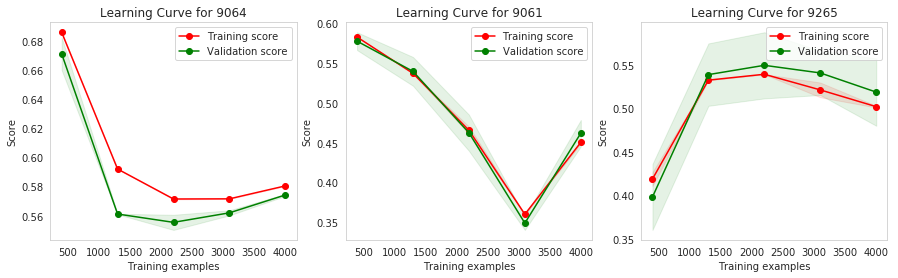

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = lob.logistic_regression(d_stocks[stock], 0, len(d_stocks[stock]))
    lob.plot_learning_curve(
        log_clf, d_stocks[stock][['prev_queue_imbalance', 'queue_imbalance']],
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=2), ax=ax[i], scoring='f1')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
if should_save_fig:
    plt.savefig('logistic_regression_learning_curves_prev_imb.png')

In [6]:
def logistic_regression(df):
    clf = LogisticRegression()
    X = df[['prev_queue_imbalance', 'queue_imbalance']]
    y = df['mid_price_indicator']
    clf.fit(X, y)
    return clf

11999 2999
11999 2999
11999 2999


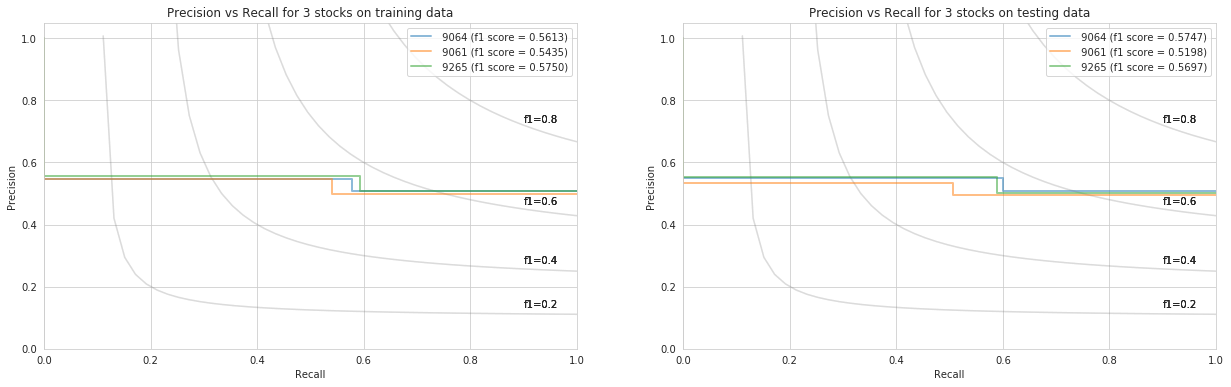

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21,6))
for stock in stocks:
    log_clf = logistic_regression(d_stocks[stock])
    pred_train = log_clf.predict(d_stocks[stock][['prev_queue_imbalance', 'queue_imbalance']])
    pred_test = log_clf.predict(d_test_stocks[stock][['prev_queue_imbalance', 'queue_imbalance']])
    d_stocks[stock]['pred_log'] = pred_train
    d_test_stocks[stock]['pred_log'] = pred_test
    print(len(d_stocks[stock]), len(d_test_stocks[stock]) )
    lob.plot_f1(d_stocks[stock], log_clf, stock=stock, label='', ax=ax1,
                 title='Precision vs Recall for 3 stocks on training data', 
                features=['prev_queue_imbalance', 'queue_imbalance'])
    lob.plot_f1(d_test_stocks[stock], log_clf, stock=stock, label='', ax=ax2,
                 title='Precision vs Recall for 3 stocks on testing data',
                features=['prev_queue_imbalance', 'queue_imbalance'])
if should_save_fig:
    plt.savefig('logistic_regression_precision_vs_recall_prev_imb.png')

In [8]:
def get_scores_dict_for_data(functions_to_run, dfs, clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = clf.predict(df[['prev_queue_imbalance', 'queue_imbalance']])
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score,  
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = logistic_regression(d_stocks[stock])
    dfs = {'test': d_test_stocks[stock]}
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    
    res_train = model.validate_model(LogisticRegression(), d_stocks[stock][['queue_imbalance']], 
                         d_stocks[stock]['mid_price_indicator'])
    res = {**res, **res_train}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

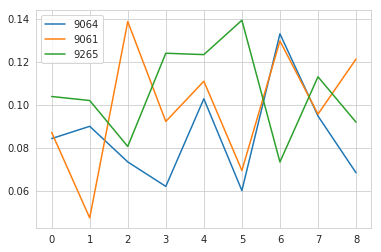

In [12]:
for i in range(len(stocks)):
    plt.plot(df_scores['matthews'].values[i], label=stocks[i])
plt.legend()

In [13]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
9064,0.564687,0.084566,0.085422,0.54705,0.586745,0.542319,9064,0.574741,0.093263,0.093668,0.550751,0.600917,0.546555,0.573239,0.068696,0.069288,0.540704,0.610831,0.534256
9061,0.514608,0.096327,0.099206,0.55253,0.495046,0.548416,9061,0.519848,0.071928,0.072028,0.534422,0.506048,0.535949,0.511331,0.090560,0.091370,0.540122,0.488456,0.545108
9265,0.556910,0.104974,0.105777,0.56196,0.555824,0.552555,9265,0.569677,0.110311,0.110547,0.552220,0.588274,0.555152,0.552519,0.110357,0.110593,0.554326,0.551871,0.555123


In [14]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 
                 'train_roc_auc', 'roc_auc', 'test_roc_auc']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &  matthews &  test\_matthews &  train\_roc\_auc &   roc\_auc &  test\_roc\_auc \\
\midrule
9064 &        0.069288 &  0.085422 &       0.093668 &       0.534256 &  0.542319 &      0.546555 \\
9061 &        0.091370 &  0.099206 &       0.072028 &       0.545108 &  0.548416 &      0.535949 \\
9265 &        0.110593 &  0.105777 &       0.110547 &       0.555123 &  0.552555 &      0.555152 \\
\bottomrule
\end{tabular}



In [15]:
print(df_scores[['f1', 'test_f1_score', 'precision', 'test_precision', 'recall', 'test_recall']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        f1 &  test\_f1\_score &  precision &  test\_precision &    recall &  test\_recall \\
\midrule
9064 &  0.564687 &       0.574741 &    0.54705 &        0.550751 &  0.586745 &     0.600917 \\
9061 &  0.514608 &       0.519848 &    0.55253 &        0.534422 &  0.495046 &     0.506048 \\
9265 &  0.556910 &       0.569677 &    0.56196 &        0.552220 &  0.555824 &     0.588274 \\
\bottomrule
\end{tabular}



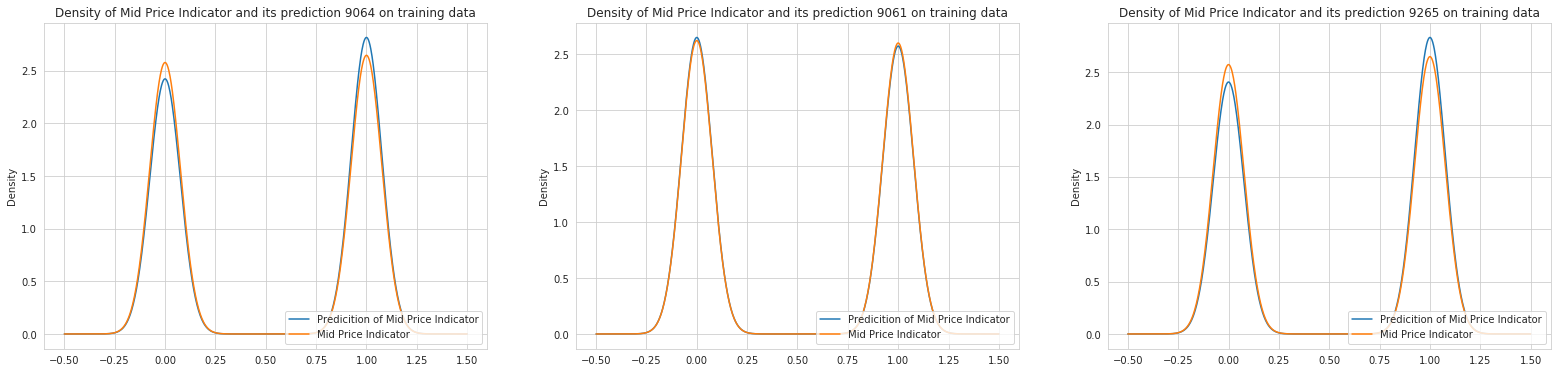

In [16]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    d_stocks[stock][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(stock))
    ax[i].legend(loc='lower right')
plt.savefig('density_of_mid_price_and_prediction_training_data_prev_imb.png')

Saving figure


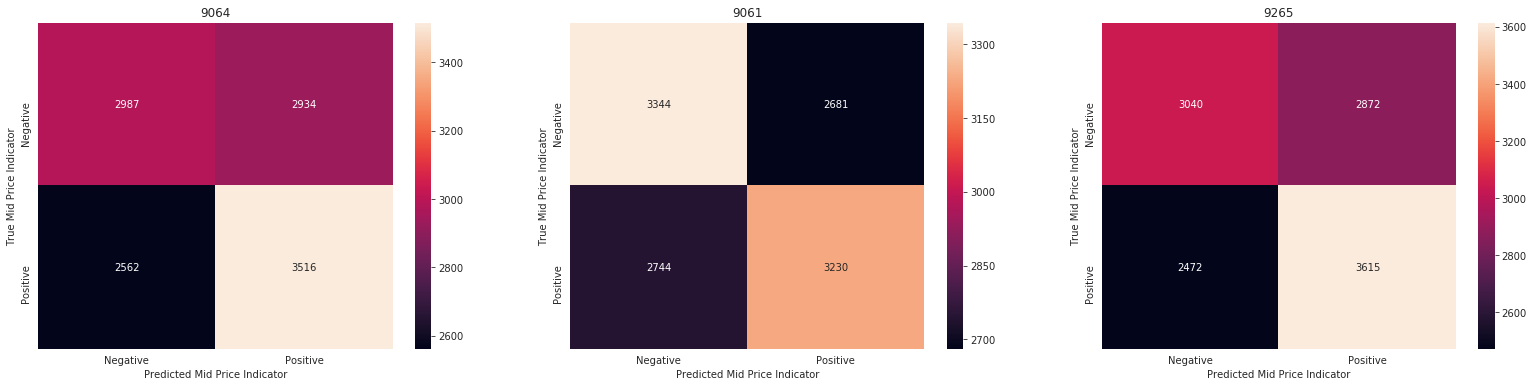

In [20]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    sns.heatmap(metrics.confusion_matrix(d_stocks[stock]['mid_price_indicator'], d_stocks[stock]['pred_log']), 
               ax=ax[i], annot=True, fmt='d', xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    
    ax[i].set_title('{}'.format(stock))
    ax[i].set_ylabel('True Mid Price Indicator')
    ax[i].set_xlabel('Predicted Mid Price Indicator')
if should_save_fig:
    print('Saving figure')
    plt.savefig('logistic_prev_imb_confusion_matrix.png')

In [ ]:
f, ax = plt.subplots(3, 1, figsize=(16, 16))
i = 0

for i in range(len(stocks)):
    stock = stocks[i]
    df = d_stocks[stock]
    X = df[['prev_queue_imbalance', 'queue_imbalance']].values
    y = df['mid_price_indicator'].values.astype(np.integer)

    clf = logistic_regression(df)
    # plot_decision_regions(X[0:1000], y[0:1000], clf=clf, ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Prev Queue Imbalance')
    ax[i].set_ylabel('Queue Imbalance')
    
    ax[i].set_title('Logistic Regression Decision Regions for {} on training data'.format(stock))
    ax[i].set_xlim(-1.01, 1.01)

if should_save_fig:
    plt.savefig('logistic_regression_decision_region_prev_imb.png'.format(s))